# Data Mining 1
## Neuronale Netze - Beispielprogramm
### Implementierung eines neuronalen Netzes ohne Hidden Layer

### 1 - Preparations
#### 1.1 - Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
import pandas as pd

# Display plots inline and change default figure size
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#### 1.2 - Generating a dataset

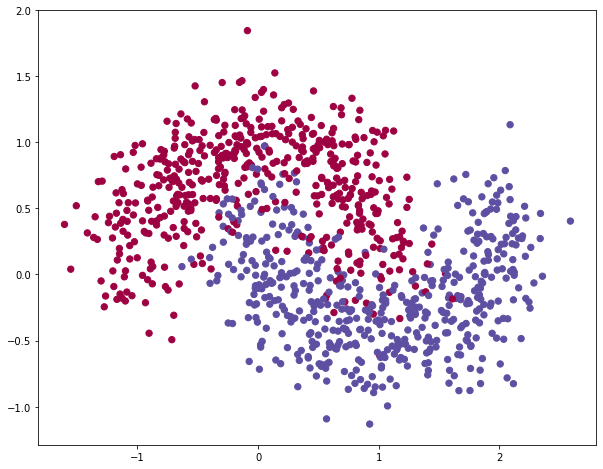

In [2]:
# Generate a dataset and plot it
n          = 1000
data_seed  = 1337
split_seed = 42
test_size  = 0.25

np.random.seed(data_seed)
X, y = sklearn.datasets.make_moons(n, noise=0.25)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral);

#### 1.3 - Split the dataset

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=test_size, 
                                                    random_state=split_seed)

##### Training Data:

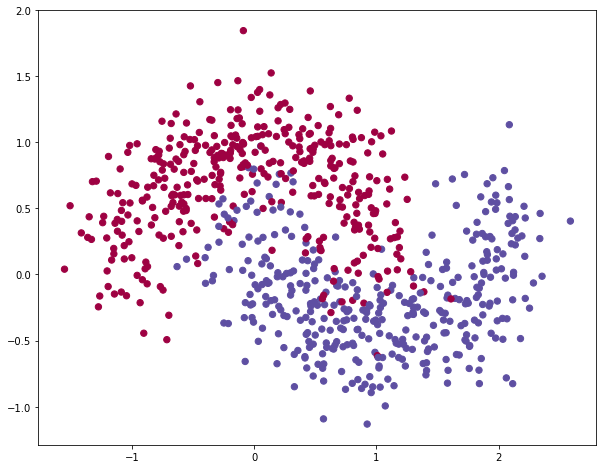

In [4]:
plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral);

##### Validation Data:

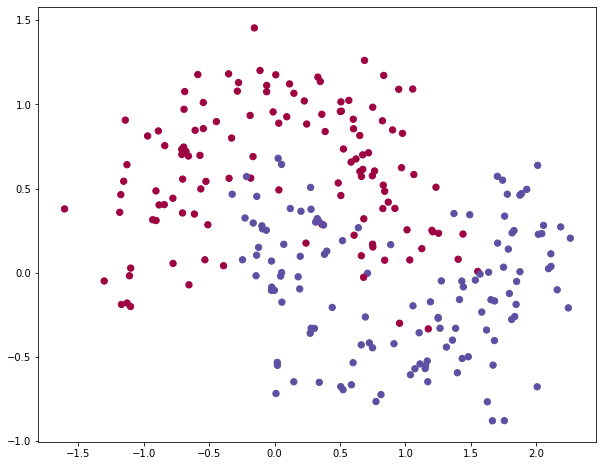

In [5]:
plt.scatter(X_test[:,0], X_test[:,1], s=40, c=y_test, cmap=plt.cm.Spectral);

### 2- Implementierung
#### 2.1 - Aktivierungsfunktion (activation function)
Als Aktivierungsfunktion des Output-Layers wird die logistische Funktion 

$\displaystyle \sigma\colon \,\mathbb{R}\to \left(0,1\right), \;z \mapsto\frac{1}{1+\exp(-z)}$ 

verwendet.

In [6]:
def sigmoid(z, derivation = False):
    if derivation:
        return sigmoid(z)*(1-sigmoid(z))
    else:
        return 1/(1+np.exp(-z))

value = 1
print(sigmoid(value))
print(sigmoid(value,True))

0.7310585786300049
0.19661193324148185


#### 2.2 Kostenfunktion (cost function)
Als Kostenfunktion wird folgende quadratische Fehlerfunktion verwendet:

$\displaystyle E(y,\widehat{\pi}) = \frac{1}{2}\sum_{k=1}^{n}\left(y_k-\widehat{\pi_k}\right)^2$

wobei $y=\left(y_1,\dots,y_n\right)^T$ und $\widehat{\pi}=\left(\widehat{\pi_1},\dots,\widehat{\pi_n}\right)^T$.

In [7]:
def calculate_loss(model,X,y):
    # Extraktion der Modellparameter
    W1, b1 = model['W1'], model['b1']
    
    # Berechnung der geschätzten Klassenwahrscheinlichkeiten (Forward Propagation)
    z1 = X.dot(W1) + b1
    probs = sigmoid(z1)[:,0]
    
    # Berechnung des Kostenfunktionswertes
    cost = np.power(y-probs,2)
    cost = np.sum(cost)/2
    
    return cost

#### 2.3 - Hilfsfunktion für Vorhersagen
- **model:** Ein Modell aus Abschnitt 2.4
- **x:** Neue Daten
- **proba:**
    - *True:* Geschätzte Wahrscheinlichkeiten werden zurückgegeben
    - *False:* Geschätzte Klassen werden zurückgegeben
- **cutpoint:** Schnittpunkt entscheidet welche Klasse prognostiziert wird

In [8]:
def predict(model, x,proba = False,cutpoint = 0.5):
    
    # Extraktion der Modellparameter
    W1, b1 = model['W1'], model['b1']

    # Berechnung der geschätzten Klassenwahrscheinlichkeiten (Forward Propagation)
    z1 = x.dot(W1) + b1
    probs = sigmoid(z1)
    
    if(proba):
        return probs
    return (probs>cutpoint)*1

#### 2.4 - Implementierung des Modells

In [9]:
def build_model(X,                              # Features
                y,                              # Target
                iterations            = 20000,  # Number of gradient descent iterations
                print_loss            = False,  # Print cost function during model adjustment
                print_loss_after_iter = 100,    # Number of iterations after cost function is to be printed
                learing_rate          = 0.1,    # Learning rate of Gradient descent
                random_state          = None):  # Random seed of weights 

    observations = X.shape[0] # Number of observations
    features     = X.shape[1] # Number of features

    # Initialize the parameters to random values:
    rand_range = 0.05
    np.random.seed(random_state)
    W1 = np.random.uniform(low = -rand_range, 
                           high = rand_range, 
                           size= (features,1))
    b1 = np.zeros((1,1))
    
    # This is what we return at the end
    model = {}

    # Gradient descent:
    for i in range(0, iterations):

        # Forward propagation
        z1 = X.dot(W1) + b1
        probs = sigmoid(z1)

        # Backpropagation       
        delta = (probs-y.reshape((observations,1))) * probs * (1 - probs)
        dW1 = np.dot(X.T, delta)
        db1 = np.sum(delta, axis=0)

        # Gradient descent parameter update
        W1 += -learing_rate * dW1
        b1 += -learing_rate * db1
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % print_loss_after_iter == 0:
            print("Loss after iteration %7d:\t%f" %(i, calculate_loss(model,X,y)))
    return model

#### 2.5 Anpassung des Modells

In [10]:
model = build_model(X            = X_train,
                    y            = y_train, 
                    iterations   = 1000,
                    print_loss   = True,
                    random_state = 42)

Loss after iteration       0:	55.524902
Loss after iteration     100:	34.838308
Loss after iteration     200:	34.838308
Loss after iteration     300:	34.838308
Loss after iteration     400:	34.838308
Loss after iteration     500:	34.838308
Loss after iteration     600:	34.838308
Loss after iteration     700:	34.838308
Loss after iteration     800:	34.838308
Loss after iteration     900:	34.838308


### 3 - Auswertung der Ergebnisse
#### 3.1 - Grafische Veranschaulichung des Modells

In [11]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(pred_func,X,y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

##### 3.1.1 - Gesamter Datensatz

In [12]:
plot_decision_boundary(lambda x: predict(model, x),X,y);

##### 3.1.2 - Trainingsdaten

In [13]:
plot_decision_boundary(lambda x: predict(model, x),X_train,y_train);

##### 3.1.3 - Validierungsdaten

In [14]:
plot_decision_boundary(lambda x: predict(model, x),X_test,y_test);

#### 3.2 ROC curve

In [15]:
# calculate the fpr and tpr for all thresholds of the classification
# Training Data
probs_train = predict(model,X_train,proba=True)
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train)
auc_train = auc(fpr_train, tpr_train)

# Validation Data
probs_test = predict(model,X_test,proba=True)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test)
auc_test = auc(fpr_test, tpr_test)

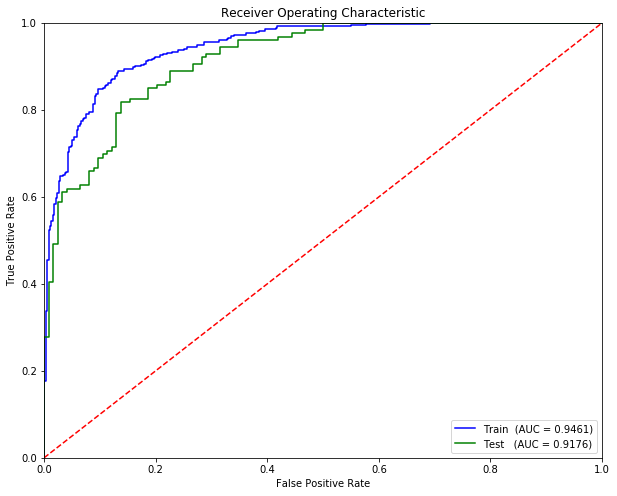

In [16]:
# Plot ROC curves + AUC values
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label = 'Train  (AUC = %0.4f)' % auc_train)
plt.plot(fpr_test,  tpr_test,  'g', label = 'Test   (AUC = %0.4f)' % auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

#### 3.3 Confusion Matrix
##### 3.3.1 Trainingsdaten

In [17]:
y_actu_train = pd.Series(y_train, name='Actual')
y_pred_train = pd.Series(predict(model,X_train)[:,0], name='Predicted')
df_conf_train = pd.crosstab(y_actu_train, y_pred_train)
print(df_conf_train)

Predicted    0    1
Actual             
0          328   48
1           46  328


##### 3.3.1 Validierungsdaten

In [18]:
y_actu_test = pd.Series(y_test, name='Actual')
y_pred_test = pd.Series(predict(model,X_test)[:,0], name='Predicted')
df_conf_test = pd.crosstab(y_actu_test, y_pred_test)
print(df_conf_test)

Predicted    0    1
Actual             
0          105   19
1           22  104


#### 3.4 Metriken

In [19]:
acc_train = accuracy_score(y_actu_train,y_pred_train)
acc_test  = accuracy_score(y_actu_test, y_pred_test)
print("-- Accuracy --")
print("Train:\t{:2.2f}%".format(acc_train*100))
print("Test:\t{:2.2f}%".format(acc_test*100))
print("\n-- Misclassification Rate --")
print("Train:\t{:2.2f}%".format((1-acc_train)*100))
print("Test:\t{:2.2f}%".format((1-acc_test)*100))

-- Accuracy --
Train:	87.47%
Test:	83.60%

-- Misclassification Rate --
Train:	12.53%
Test:	16.40%


## 4 Deep Learning Library Keras
#### 4.1 Aufbau und Training des Modells
Mithilfe von Keras können einzelne Layer sequentiell dem Modell hinzugefügt werden. Siehe [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/) und [The Sequential model API](https://keras.io/models/sequential/)
Unter anderem sind dabei folgende Punkte zu beachten:
* Beim ersten Layer muss mit **input_dim**, die Anzahl der Features (abhängigen Merkmalsvariablen) angegeben werden
* Beim letzten Layer muss die Anzahl der Neuronen mit der Anzahl der Targets übereinstimmen

Alle nötigen Informationen zum Umgang mit Keras können Sie auf der offiziellen Seite von Keras finden:
**[Keras: The Python Deep Learning library](https://keras.io)**

In [20]:
#Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import RandomUniform,Constant

#START A NEW TF SESSION - Für Reproduzierbarkeit notwendig
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(1337)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
tf.compat.v1.keras.backend.set_session(sess)

##### 4.1.1  Aufbau des Modells
Zunächst muss mit $\texttt{Sequential}$ ein Modell-Objekt erzeugt werden. Anschließend können mit der Methode $\texttt{add}$ Layer hinzugefügt werden. 
- Mögliche Einstellungen der einfachen Layer: [Core Layers](https://keras.io/layers/core/)
- [Usage of activations](https://keras.io/activations/)
- [Usage of regularizers](https://keras.io/regularizers/)

In [21]:
# Build model
keras_model = Sequential()

# Add Layers
keras_model.add(Dense(1,
                activation='sigmoid',
                input_dim=2))

##### 4.1.2  Optionen für die Modellanpassung
Anschließend müssen mit der compile-Methode verschiedene Einstellungen für die Modellanpassung getroffen werden.
- **optimizer:** Optimierungsalgorithmus ([Usage of optimizers](https://keras.io/optimizers/))
- **loss:** Auswahl der gewünschten Zielfunktion nach der das Modell optimiert werden soll ([Usage of loss functions](https://keras.io/losses/))
- **metrics:** Metriken die werden der Modellanpassung berechnet werden sollen
- Weitere Parameter sind unter [The Sequential model API
](https://keras.io/models/sequential/) zu finden

In [22]:
# Training Options
keras_model.compile(optimizer='rmsprop',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

In [23]:
# Übersicht des Modells
print(keras_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None


##### 4.1.3 Anpassung des Modells
Durch die Methode $\texttt{fit}$ kann das Modell schließlich trainiert werden. Siehe hierzu wieder: 
[The Sequential model API](https://keras.io/models/sequential/)

In [24]:
# Fitting of the model
model_history = keras_model.fit(X_train, #Idealerweise sollten die Daten standardisiert werden
                                y_train, 
                                epochs          = 250,
                                validation_data = (X_test, y_test),
                                verbose         = 2,                     # 0 = kein Output 
                                batch_size      = 32)

Train on 750 samples, validate on 250 samples
Epoch 1/250
750/750 - 0s - loss: 0.7228 - accuracy: 0.1373 - val_loss: 0.7122 - val_accuracy: 0.2360
Epoch 2/250
750/750 - 0s - loss: 0.7107 - accuracy: 0.1987 - val_loss: 0.7029 - val_accuracy: 0.3160
Epoch 3/250
750/750 - 0s - loss: 0.7000 - accuracy: 0.3280 - val_loss: 0.6937 - val_accuracy: 0.4880
Epoch 4/250
750/750 - 0s - loss: 0.6894 - accuracy: 0.5387 - val_loss: 0.6848 - val_accuracy: 0.5680
Epoch 5/250
750/750 - 0s - loss: 0.6792 - accuracy: 0.6640 - val_loss: 0.6761 - val_accuracy: 0.6400
Epoch 6/250
750/750 - 0s - loss: 0.6691 - accuracy: 0.7187 - val_loss: 0.6674 - val_accuracy: 0.6600
Epoch 7/250
750/750 - 0s - loss: 0.6590 - accuracy: 0.7387 - val_loss: 0.6589 - val_accuracy: 0.6800
Epoch 8/250
750/750 - 0s - loss: 0.6492 - accuracy: 0.7653 - val_loss: 0.6508 - val_accuracy: 0.6920
Epoch 9/250
750/750 - 0s - loss: 0.6397 - accuracy: 0.7747 - val_loss: 0.6429 - val_accuracy: 0.6960
Epoch 10/250
750/750 - 0s - loss: 0.6304 - ac

Epoch 81/250
750/750 - 0s - loss: 0.3475 - accuracy: 0.8520 - val_loss: 0.4089 - val_accuracy: 0.7840
Epoch 82/250
750/750 - 0s - loss: 0.3463 - accuracy: 0.8533 - val_loss: 0.4079 - val_accuracy: 0.7840
Epoch 83/250
750/750 - 0s - loss: 0.3452 - accuracy: 0.8533 - val_loss: 0.4070 - val_accuracy: 0.7840
Epoch 84/250
750/750 - 0s - loss: 0.3441 - accuracy: 0.8533 - val_loss: 0.4061 - val_accuracy: 0.7840
Epoch 85/250
750/750 - 0s - loss: 0.3429 - accuracy: 0.8560 - val_loss: 0.4052 - val_accuracy: 0.7840
Epoch 86/250
750/750 - 0s - loss: 0.3419 - accuracy: 0.8573 - val_loss: 0.4044 - val_accuracy: 0.7840
Epoch 87/250
750/750 - 0s - loss: 0.3409 - accuracy: 0.8587 - val_loss: 0.4036 - val_accuracy: 0.7840
Epoch 88/250
750/750 - 0s - loss: 0.3399 - accuracy: 0.8573 - val_loss: 0.4028 - val_accuracy: 0.7840
Epoch 89/250
750/750 - 0s - loss: 0.3389 - accuracy: 0.8587 - val_loss: 0.4020 - val_accuracy: 0.7840
Epoch 90/250
750/750 - 0s - loss: 0.3380 - accuracy: 0.8587 - val_loss: 0.4012 - v

Epoch 161/250
750/750 - 0s - loss: 0.3049 - accuracy: 0.8720 - val_loss: 0.3716 - val_accuracy: 0.8160
Epoch 162/250
750/750 - 0s - loss: 0.3048 - accuracy: 0.8720 - val_loss: 0.3714 - val_accuracy: 0.8160
Epoch 163/250
750/750 - 0s - loss: 0.3046 - accuracy: 0.8733 - val_loss: 0.3713 - val_accuracy: 0.8160
Epoch 164/250
750/750 - 0s - loss: 0.3045 - accuracy: 0.8720 - val_loss: 0.3712 - val_accuracy: 0.8200
Epoch 165/250
750/750 - 0s - loss: 0.3043 - accuracy: 0.8720 - val_loss: 0.3710 - val_accuracy: 0.8240
Epoch 166/250
750/750 - 0s - loss: 0.3042 - accuracy: 0.8733 - val_loss: 0.3708 - val_accuracy: 0.8240
Epoch 167/250
750/750 - 0s - loss: 0.3041 - accuracy: 0.8720 - val_loss: 0.3707 - val_accuracy: 0.8240
Epoch 168/250
750/750 - 0s - loss: 0.3040 - accuracy: 0.8720 - val_loss: 0.3705 - val_accuracy: 0.8240
Epoch 169/250
750/750 - 0s - loss: 0.3038 - accuracy: 0.8720 - val_loss: 0.3704 - val_accuracy: 0.8240
Epoch 170/250
750/750 - 0s - loss: 0.3037 - accuracy: 0.8720 - val_loss: 

Epoch 241/250
750/750 - 0s - loss: 0.3001 - accuracy: 0.8693 - val_loss: 0.3657 - val_accuracy: 0.8320
Epoch 242/250
750/750 - 0s - loss: 0.3001 - accuracy: 0.8693 - val_loss: 0.3656 - val_accuracy: 0.8320
Epoch 243/250
750/750 - 0s - loss: 0.3001 - accuracy: 0.8693 - val_loss: 0.3655 - val_accuracy: 0.8320
Epoch 244/250
750/750 - 0s - loss: 0.3001 - accuracy: 0.8693 - val_loss: 0.3655 - val_accuracy: 0.8320
Epoch 245/250
750/750 - 0s - loss: 0.3000 - accuracy: 0.8693 - val_loss: 0.3655 - val_accuracy: 0.8320
Epoch 246/250
750/750 - 0s - loss: 0.3000 - accuracy: 0.8693 - val_loss: 0.3655 - val_accuracy: 0.8320
Epoch 247/250
750/750 - 0s - loss: 0.3000 - accuracy: 0.8693 - val_loss: 0.3654 - val_accuracy: 0.8320
Epoch 248/250
750/750 - 0s - loss: 0.3000 - accuracy: 0.8693 - val_loss: 0.3654 - val_accuracy: 0.8320
Epoch 249/250
750/750 - 0s - loss: 0.3000 - accuracy: 0.8693 - val_loss: 0.3654 - val_accuracy: 0.8320
Epoch 250/250
750/750 - 0s - loss: 0.3000 - accuracy: 0.8693 - val_loss: 

#### 4.2 Auswertungen
##### 4.2.1 Zielfunktion und Genauigkeit im Verlauf der Epochen

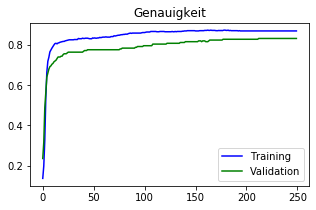

In [25]:
# Kostenfunktion
plt.figure(figsize=(5,3))
plt.plot(model_history.epoch,
         model_history.history['loss'], 
         'b', 
         label = "Training")
plt.plot(model_history.epoch,
         model_history.history['val_loss'],
         'g',
         label = "Validation")
plt.legend(loc = 'upper right')
plt.title('Kostenfunktion');

# Genauigkeit
plt.figure(figsize=(5,3))
plt.plot(model_history.epoch,
         model_history.history['accuracy'],
        'b',
        label = "Training")
plt.plot(model_history.epoch,
         model_history.history['val_accuracy'],
        'g',
        label= "Validation")
plt.legend(loc = 'lower right')
plt.title('Genauigkeit');

##### 4.2.2 Grafische Darstellung des Modells

**Gesamter Datensatz**

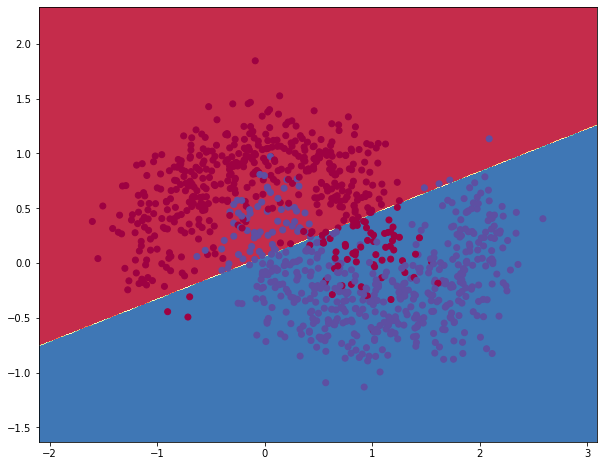

In [26]:
plot_decision_boundary(lambda x: keras_model.predict_classes(x),X,y);

**Trainingsdaten**

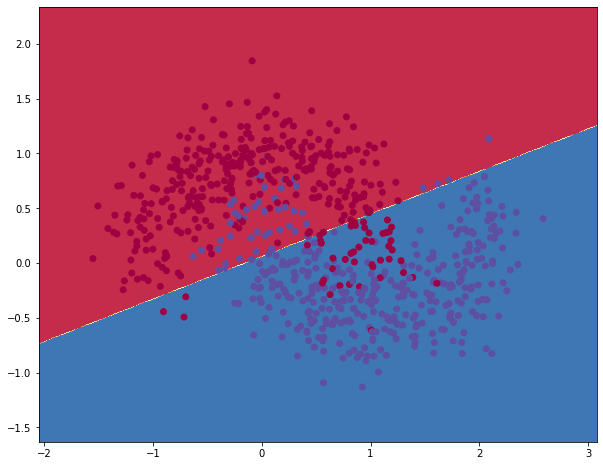

In [27]:
plot_decision_boundary(lambda x: keras_model.predict_classes(x),X_train,y_train);

**Validierungsdaten**

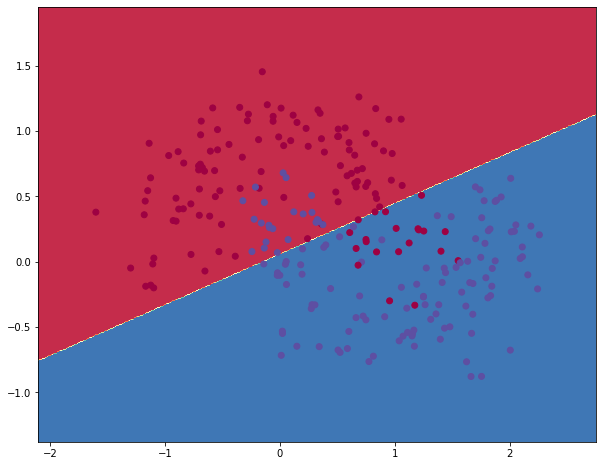

In [28]:
plot_decision_boundary(lambda x: keras_model.predict_classes(x),X_test,y_test);

##### 4.2.4 ROC curve

In [29]:
# calculate the fpr and tpr for all thresholds of the classification
# Training Data
probs_train = keras_model.predict_proba(X_train)
fpr_train, tpr_train, _ = roc_curve(y_train, probs_train[:,0])
auc_train = auc(fpr_train, tpr_train)

# Validation Data
probs_test = keras_model.predict_proba(X_test)
fpr_test, tpr_test, _ = roc_curve(y_test, probs_test[:,0])
auc_test = auc(fpr_test, tpr_test)

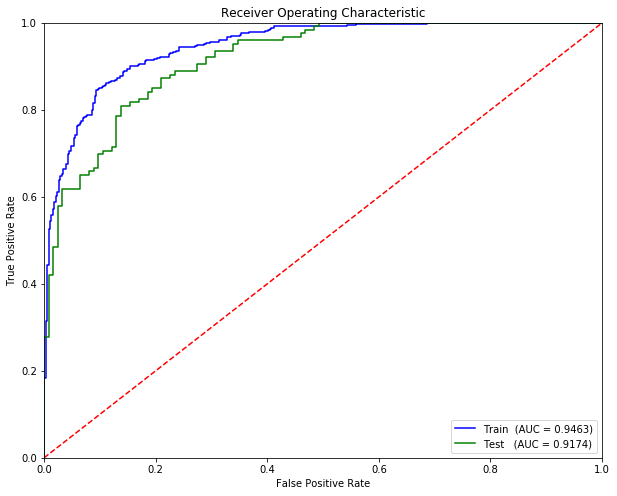

In [30]:
# Plot ROC curves + AUC values
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'b', label = 'Train  (AUC = %0.4f)' % auc_train)
plt.plot(fpr_test,  tpr_test,  'g', label = 'Test   (AUC = %0.4f)' % auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

##### 4.2.5 Confusion Matrix
**Trainingsdaten**

In [31]:
y_actu_train = pd.Series(y_train, name='Actual')
y_pred_train = pd.Series(keras_model.predict_classes(X_train)[:,0], name='Predicted')
df_conf_train = pd.crosstab(y_actu_train, y_pred_train)
print(df_conf_train)

Predicted    0    1
Actual             
0          328   48
1           50  324


**Validierungsdaten**

In [32]:
y_actu_test = pd.Series(y_test, name='Actual')
y_pred_test = pd.Series(keras_model.predict_classes(X_test)[:,0], name='Predicted')
df_conf_test = pd.crosstab(y_actu_test, y_pred_test)
print(df_conf_test)

Predicted    0    1
Actual             
0          105   19
1           23  103


##### 4.2.6 Metriken

In [33]:
acc_train = accuracy_score(y_actu_train,y_pred_train)
acc_test  = accuracy_score(y_actu_test, y_pred_test)
print("-- Accuracy --")
print("Train:\t{:2.2f}%".format(acc_train*100))
print("Test:\t{:2.2f}%".format(acc_test*100))
print("\n-- Misclassification Rate --")
print("Train:\t{:2.2f}%".format((1-acc_train)*100))
print("Test:\t{:2.2f}%".format((1-acc_test)*100))

-- Accuracy --
Train:	86.93%
Test:	83.20%

-- Misclassification Rate --
Train:	13.07%
Test:	16.80%


In [34]:
#CLOSE TF SESSION
tf.compat.v1.keras.backend.clear_session()